In [39]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload to reload all modules
%autoreload 2
import pandas as pd
import seaborn as sns
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Dynamically locate the src/ directory
src_dir = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]
sys.path.insert(0, str(src_dir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from utils.db_utils import DatabaseConnection

In [ ]:
with DatabaseConnection() as engine:
    df = pd.read_sql(
        """
        select *
        from air_quality
        """,
        engine
    )
print(df.head())
print(df.dtypes)

                _time  pm10  pm2_5  carbon_monoxide  carbon_dioxide  \
0 2025-02-27 00:00:00  13.4   12.6            352.0           452.0   
1 2025-02-27 01:00:00  13.3   12.6            328.0           452.0   
2 2025-02-27 02:00:00  12.7   12.0            276.0           451.0   
3 2025-02-27 03:00:00  11.1   10.5            235.0           450.0   
4 2025-02-27 04:00:00   9.1    8.6            224.0           450.0   

   nitrogen_dioxide  sulphur_dioxide  ozone  methane  uv_index  dust  \
0              24.3              3.7   69.0   1431.0       0.0   1.0   
1              21.2              3.2   72.0   1434.0       0.0   1.0   
2              16.8              2.4   77.0   1432.0       0.0   1.0   
3              12.9              1.8   81.0   1431.0       0.0   1.0   
4              10.2              1.3   83.0   1431.0       0.0   1.0   

   aerosol_optical_depth  us_aqi                insert_time  
0                   0.10      42 2025-05-29 16:56:28.841911  
1               

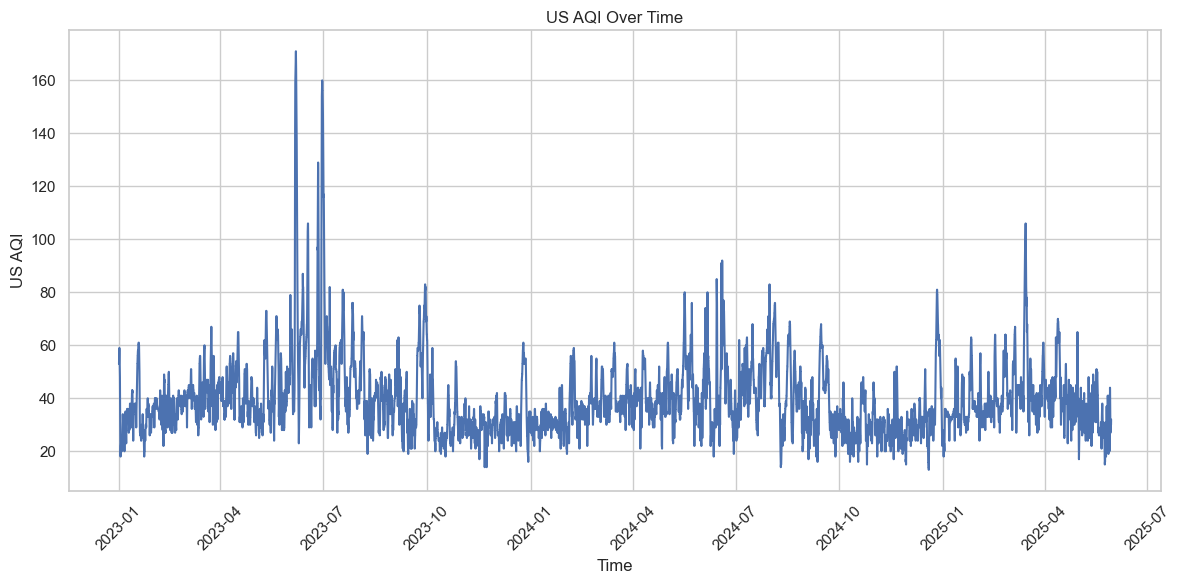

In [ ]:
sns.set_theme(style="whitegrid")

# Create time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="_time", y="us_aqi")
plt.title("US AQI Over Time")
plt.xlabel("Time")
plt.ylabel("US AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Excellent. So we can clearly see that there is a seasonal trend in the air quality. The large spike between April and July 2023 most likely coincides with the forest fires from alberta where smoke was spreading across eastern Canada. We can also see that as we get into the late fall / early winter months, the air quality dips down, with increases in towards the late spring early summer months. There is a clear trend in air quality throughout time. The large spikes in these warmer months can be attributed to climate change within canada and hot humid days that pose a severe health risk. In cominbation with the forest firest in western canada, this can contribute to the seasonal qir quality. Given how large an impact the forest fires had in 2023, these are a large outlier for this dataset.

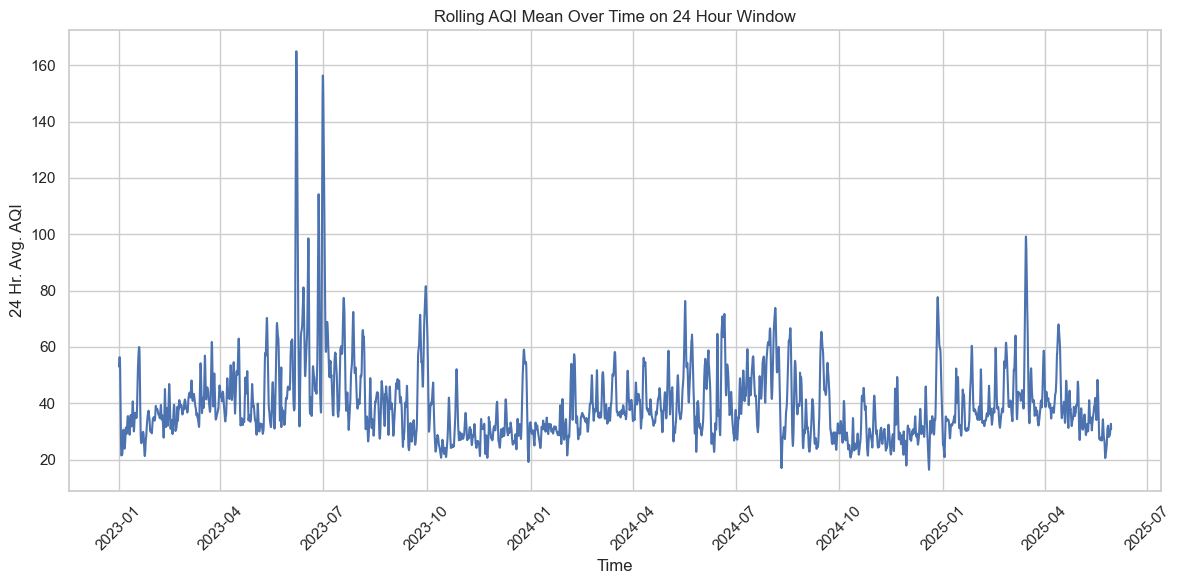

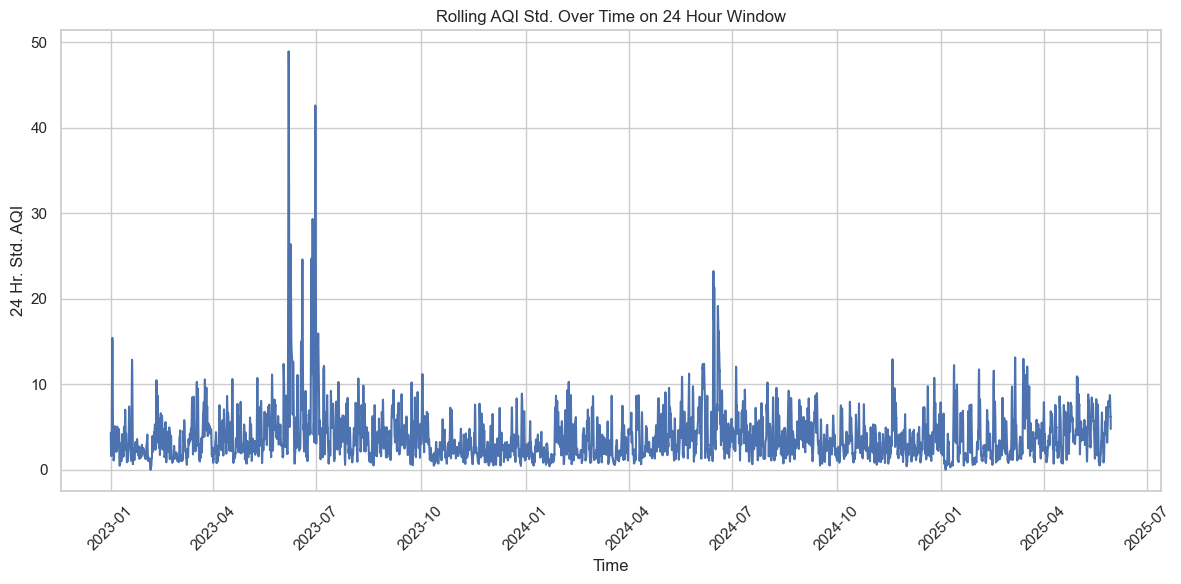

In [37]:
df['aqi_rolling_mean'] = df['us_aqi'].rolling(window=24).mean()
df['aqi_rolling_std'] = df['us_aqi'].rolling(window=24).std()

sns.set_theme(style="whitegrid")

# Create time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="_time", y="aqi_rolling_mean")
plt.title("Rolling AQI Mean Over Time on 24 Hour Window")
plt.xlabel("Time")
plt.ylabel("24 Hr. Avg. AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="_time", y="aqi_rolling_std")
plt.title("Rolling AQI Std. Over Time on 24 Hour Window")
plt.xlabel("Time")
plt.ylabel("24 Hr. Std. AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It's much easier to see the seasonal component now in the rolling average

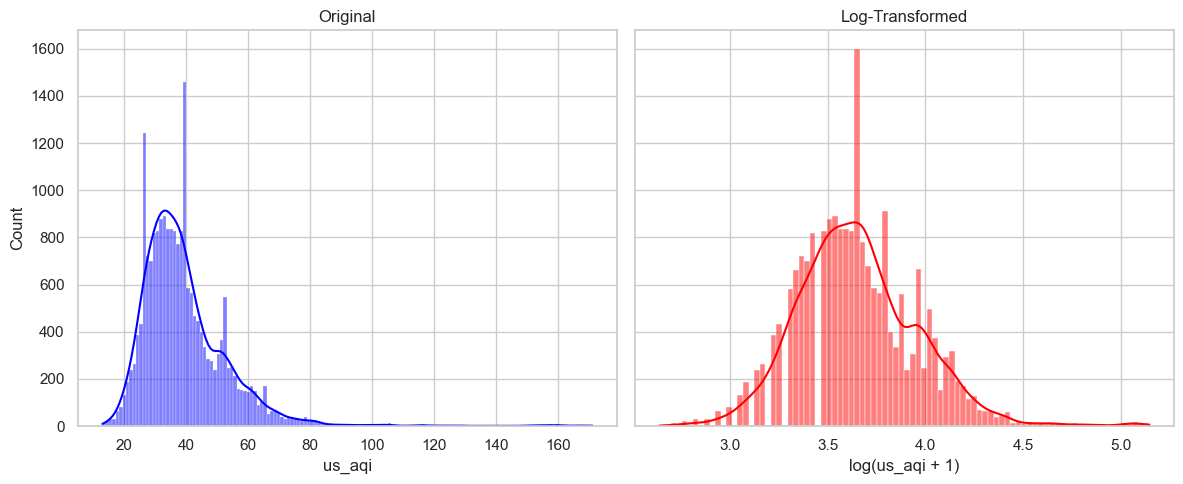

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Original
sns.histplot(df['us_aqi'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Original')
axes[0].set_xlabel('us_aqi')

# Log Transformed
sns.histplot(np.log1p(df['us_aqi']), kde=True, color='red', ax=axes[1])
axes[1].set_title('Log-Transformed')
axes[1].set_xlabel('log(us_aqi + 1)')

plt.tight_layout()
plt.show()

Clearly we have a right-skewed distribution. This is largely in part of the AQI of 160 from the forest fires in alberta. Log transformations help us achieve a more balanced dataset in this case. We just need to ensure that we apply the inverse transformation of this as output

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

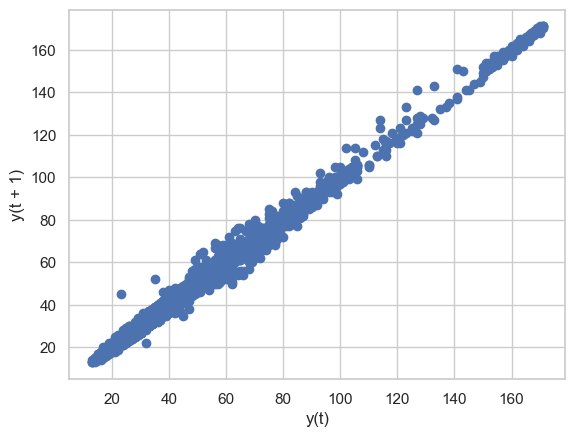

In [43]:
pd.plotting.lag_plot(df["us_aqi"])

This lag plots a very clear liner relationship exists within this data, which is to be expected as air quality does not tend to fluctuate too greatly hour to hour. However, this shows that we need to consider using previous values as part of the predictions for the LSTM model. 

<Axes: xlabel='hour', ylabel='us_aqi'>

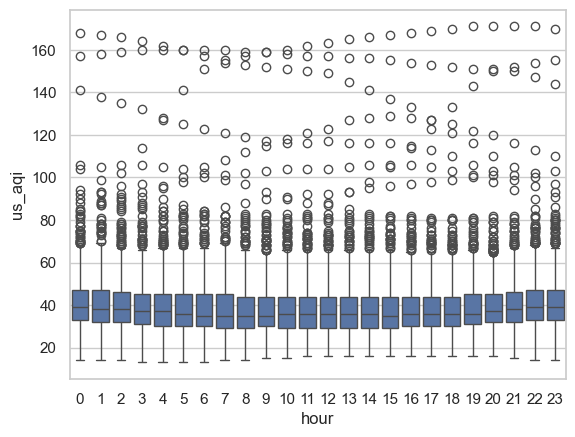

In [44]:
df['hour'] = df['_time'].dt.hour
sns.boxplot(x='hour', y='us_aqi', data=df)

The median air quality is fairly consistent across all hours of the day. While some hours have a somewhat tighter spread of AQI (3-6am for example), it's clear that day time hours have more outliers, most likely due to higher amount of traffic pollution or industrial pollution. We should encode the hours as a cyclical dependency

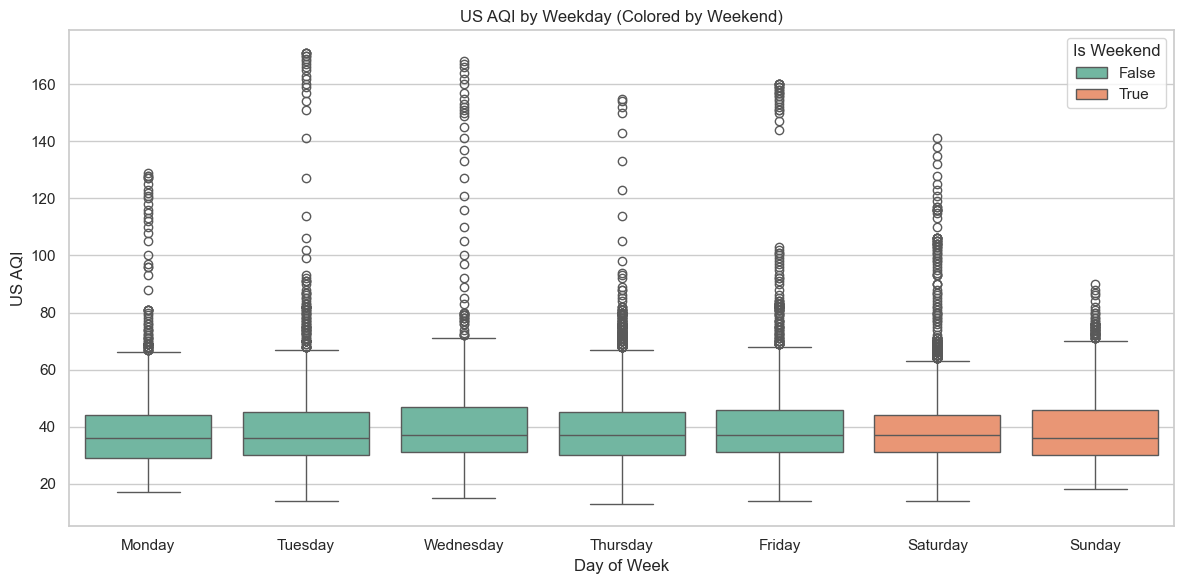

In [45]:
df['weekday'] = df['_time'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

# Order weekdays properly
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weekday', y='us_aqi', order=ordered_days, hue='is_weekend', palette='Set2')

plt.title("US AQI by Weekday (Colored by Weekend)")
plt.xlabel("Day of Week")
plt.ylabel("US AQI")
plt.legend(title="Is Weekend")
plt.tight_layout()
plt.show()

Clearly the weekend show a tigher distribution of outliers compared to week days. Median air quality is also slightly less, however the difference is almost unnoticeable. The air quality is similar across, but the range is not as drastic for weekends

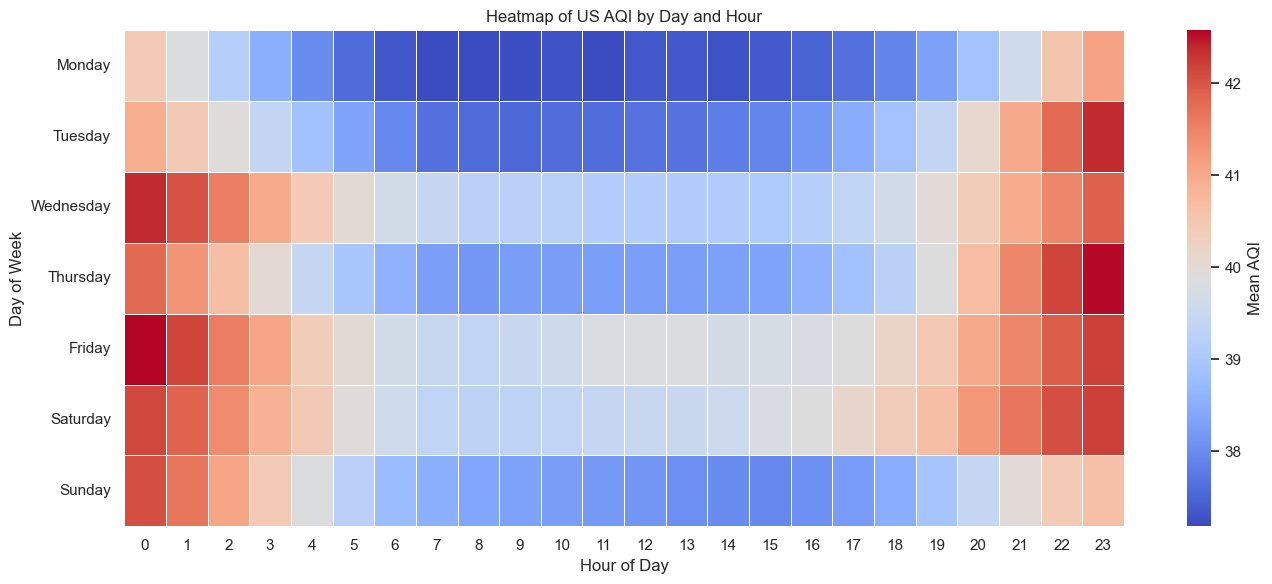

In [46]:
df['weekday'] = df['_time'].dt.day_name()
df['hour'] = df['_time'].dt.hour

# Aggregate: mean AQI per (weekday, hour)
pivot = df.groupby(['weekday', 'hour'])['us_aqi'].mean().unstack()

# Optional: order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=False, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Mean AQI'})

plt.title("Heatmap of US AQI by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

The mean AQI seems to be higher towards the later hours of the night for each days of the week

/Users/matthewbaxter/Documents/Programming/pytorch_kafka/rust_kafka/torch_weather/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/matthewbaxter/Documents/Programming/pytorch_kafka/rust_kafka/torch_weather/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/matthewbaxter/Documents/Programming/pytorch_kafka/rust_kafka/torch_weather/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/matthewbaxter/Documents/Programming/pytorch_kafka/rust_kafka/torch_weather/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_

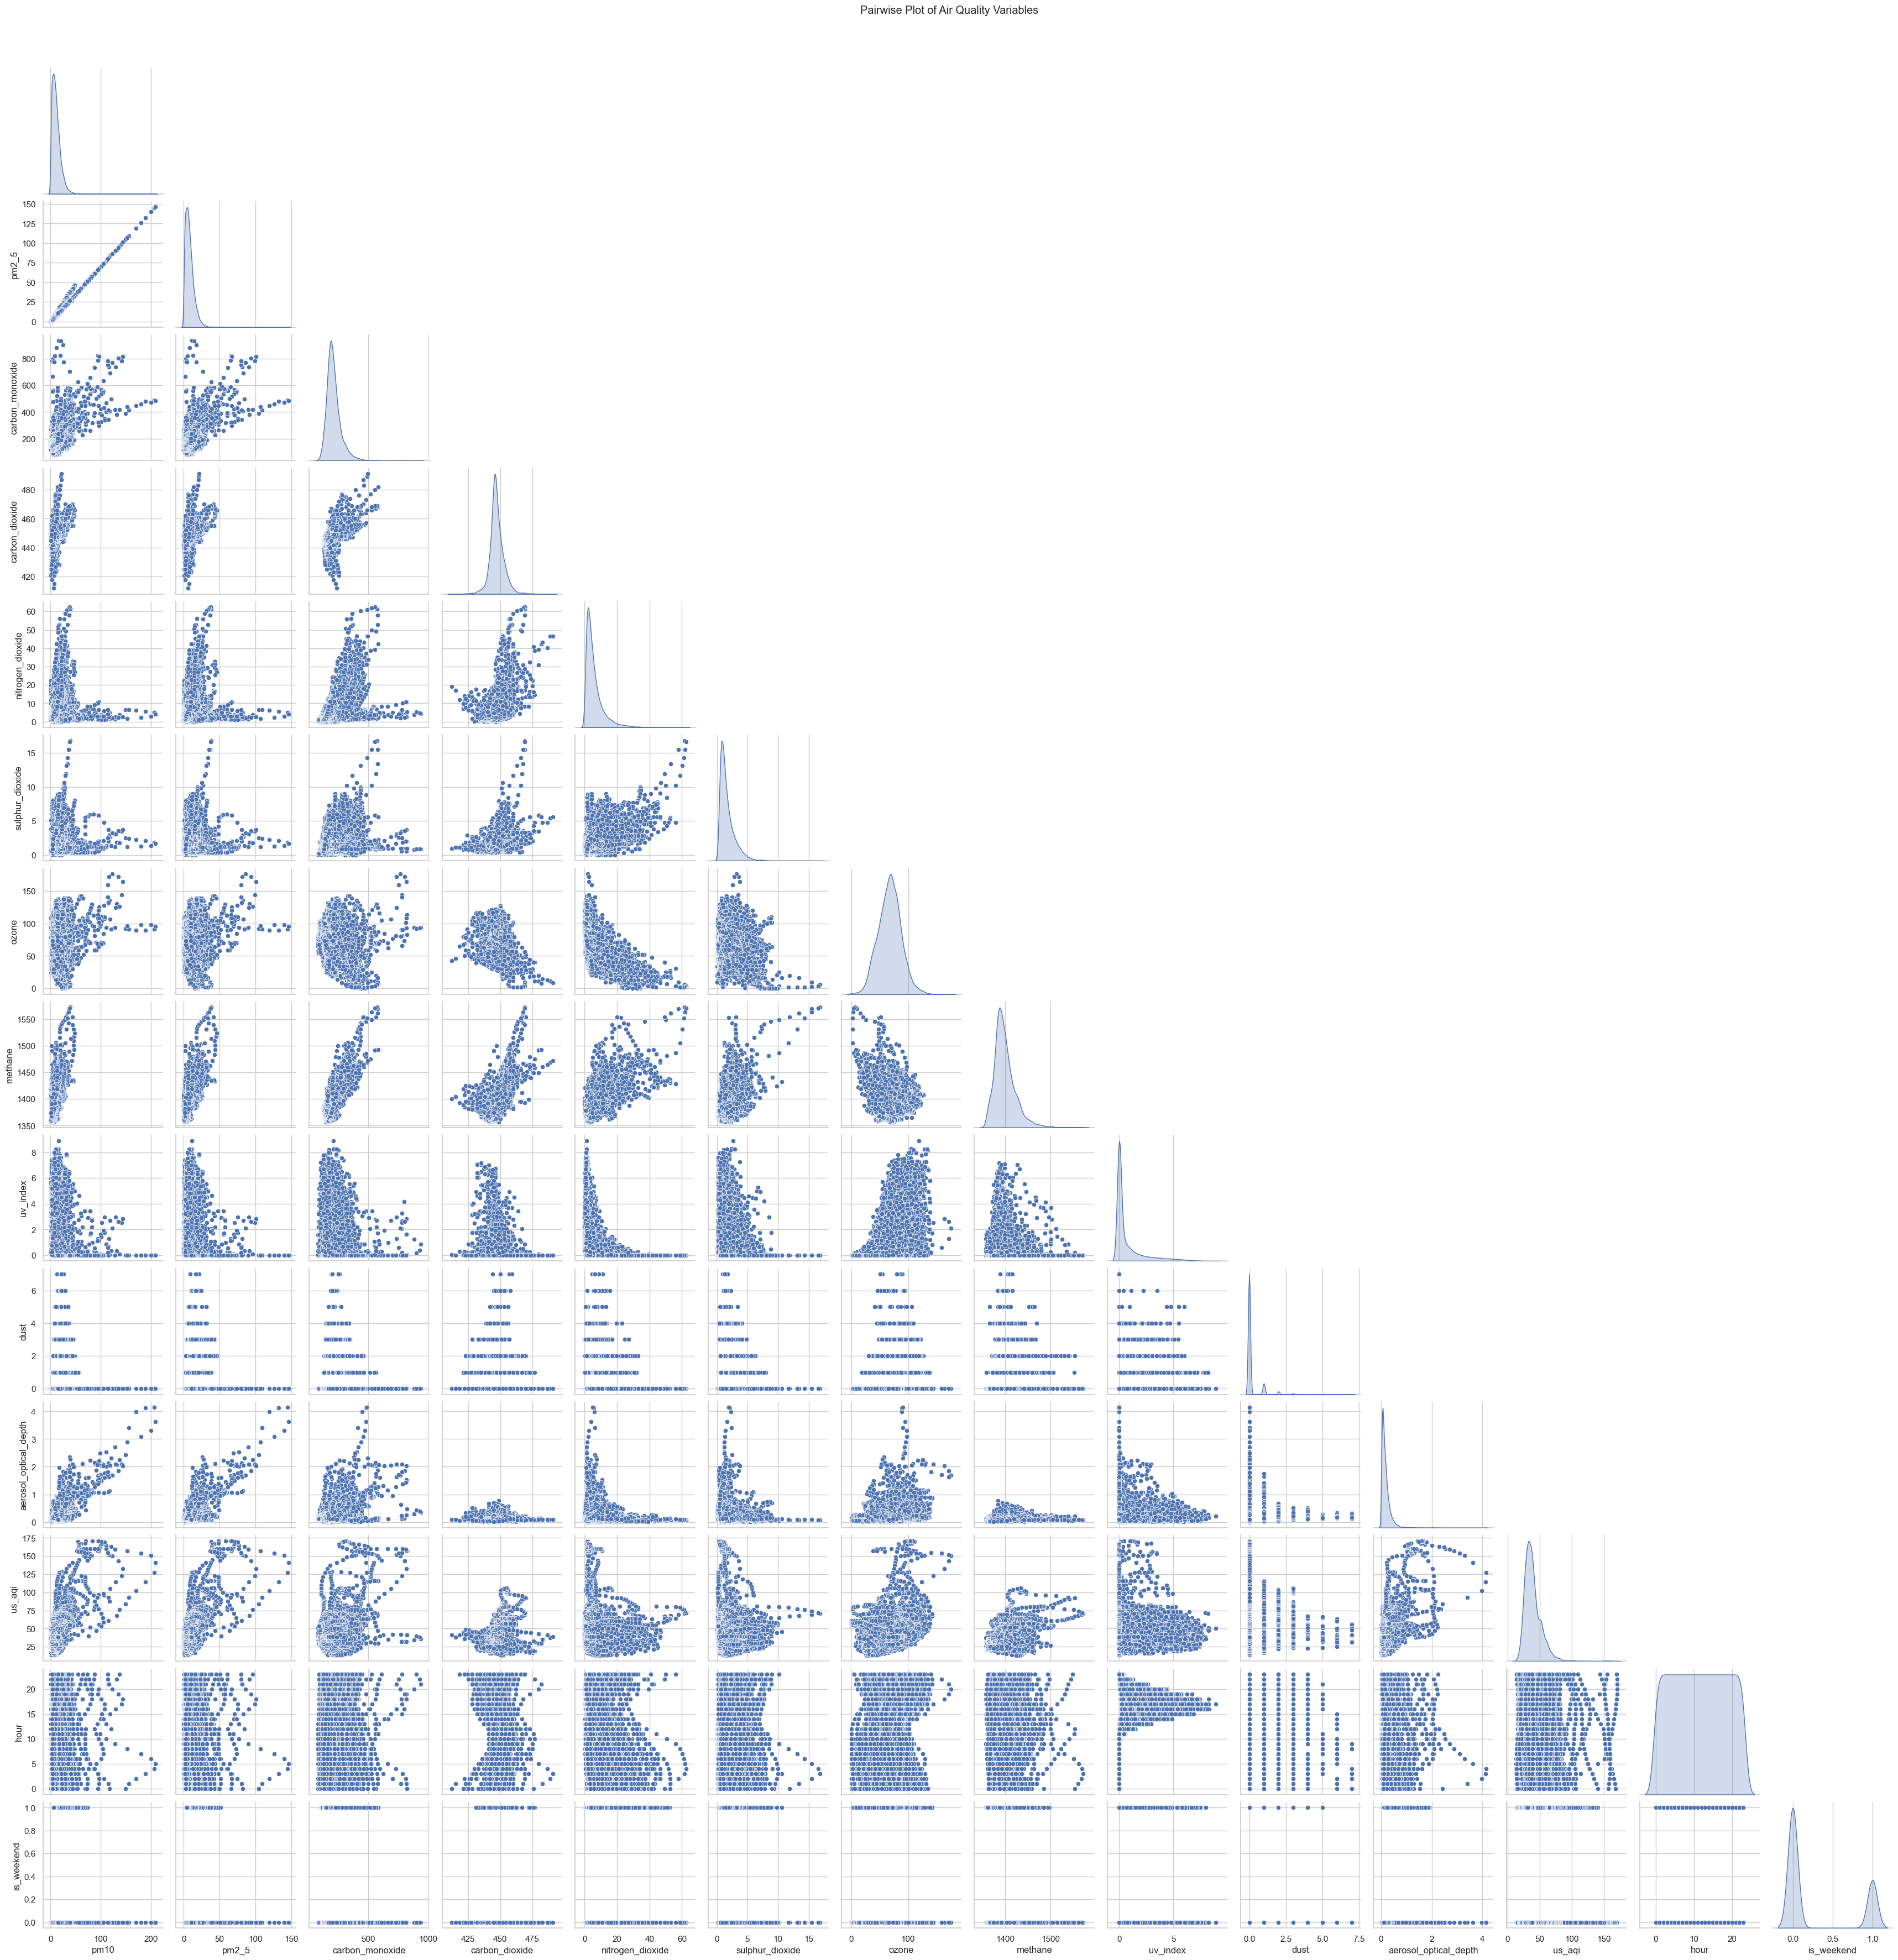

In [ ]:
cols = ['pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'methane', 'uv_index',
       'dust', 'aerosol_optical_depth', 'us_aqi', 'hour', 'weekday', 'is_weekend']
sns.pairplot(df[cols], corner=True, diag_kind='kde')
plt.suptitle("Pairwise Plot of Air Quality Variables", y=1.02)
plt.show()